In [2]:
import pandas as pd
from xgboost import XGBClassifier


In [3]:
! ls /Users/we56sc/Analytics/DataSets/

Credit_Card_Fraud
Default_Of_Credit_Card_Clients
European_Cutsomer_Credit_Card_Transactions
Home_Credit
Santander_Customer_Transaction


In [4]:
data_cc = pd.read_csv("/Users/we56sc/Analytics/DataSets/Credit_Card_Fraud/creditcard.csv")
data_taiwan = pd.read_csv("/Users/we56sc/Analytics/DataSets/Default_Of_Credit_Card_Clients/UCI_Credit_Card.csv")

In [5]:
data_cc.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
data_cc.Class.value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [7]:
data_cc.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

# Import imbalance xgboost

In [10]:
# from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb

In [9]:
data_taiwan.drop('ID',inplace=True, axis=1)

In [9]:
data_cc.drop("Time",inplace=True, axis=1)

In [10]:
from sklearn.model_selection import train_test_split


In [11]:
data_taiwan.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [12]:
 X_train, X_test, y_train, y_test = train_test_split(
     data_taiwan.drop('default.payment.next.month', axis=1), 
     data_taiwan['default.payment.next.month'], 
     test_size=0.33, random_state=42)


In [13]:
#  X_train, X_test, y_train, y_test = train_test_split(
#      data_cc.drop('Class', axis=1), 
#      data_cc['Class'], 
#      test_size=0.33, random_state=42)

## Define own Extended XGboost

In [14]:
from sklearn.metrics import roc_auc_score, f1_score

def get_auc(X,y,model):
    proba = model.predict_proba(X)[:,1]
    
    return roc_auc_score(y,proba)

def get_f1(X,y,model):
    pred = model.predict_proba(X)[:,1]>0.5
    
    return f1_score(y,pred)
    

In [15]:
XGBClassifier?

In [16]:
import numpy as np

class ExtendedXGboost(XGBClassifier):
    
    def __init__(self, imbalance_alpha = 1, gamma_indct=0,
                 max_depth=3, learning_rate=0.1,
                 n_estimators=100, verbosity=1,
                 objective="binary:logistic", booster='gbtree',
                 tree_method='auto', n_jobs=1, gpu_id=0, gamma=0,
                 min_child_weight=1, max_delta_step=0, subsample=1,
                 colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1,
                 reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5,
                 random_state=0, missing=None, **kwargs):
        
        self.imbalance_alpha = imbalance_alpha,
        self.gamma_indct = gamma_indct
        if objective =='user:focal':
            self.obj_func = self.focal_binary
            
        elif objective == 'user:weight':
            self.obj_func = self.weighted_binary_cross_entropy
            
        else:
            self.obj_func = objective
        
        super(ExtendedXGboost, self).__init__(
            max_depth=max_depth, learning_rate=learning_rate,
            n_estimators=n_estimators, verbosity=verbosity,
            objective=self.obj_func,
            booster=booster, tree_method=tree_method,
            n_jobs=n_jobs, gpu_id=gpu_id, gamma=gamma,
            min_child_weight=min_child_weight,
            max_delta_step=max_delta_step, subsample=subsample,
            colsample_bytree=colsample_bytree,
            colsample_bylevel=colsample_bylevel,
            colsample_bynode=colsample_bynode,
            reg_alpha=reg_alpha, reg_lambda=reg_lambda,
            scale_pos_weight=scale_pos_weight,
            base_score=base_score, random_state=random_state, missing=missing,
            **kwargs)
        
    def __repr__(self):
        return "This is extended XGboost with custom loss function"
        
    def robust_pow(self, num_base, num_pow):
        # numpy does not permit negative numbers to fractional power
        # use this to perform the power algorithmic

        return np.sign(num_base) * (np.abs(num_base)) ** (num_pow)

    
    def focal_binary(self, y_true, y_pred):
        
        gamma_indct = self.gamma_indct
        # retrieve data from dtrain matrix
        # compute the prediction with sigmoid
        # gradient
        # complex gradient with different parts
        g1 = y_pred * (1 - y_pred)
        g2 = y_true + ((-1) ** y_true) * y_pred
        g3 = y_pred + y_true - 1
        g4 = 1 - y_true - ((-1) ** y_true) * y_pred
        g5 = y_true + ((-1) ** y_true) * y_pred
        # combine the gradient
        grad = gamma_indct * g3 * self.robust_pow(g2, gamma_indct) * np.log(g4 + 1e-9) + \
               ((-1) ** y_true) * self.robust_pow(g5, (gamma_indct + 1))
        # combine the gradient parts to get hessian components
        hess_1 = self.robust_pow(g2, gamma_indct) + \
                 gamma_indct * ((-1) ** y_true) * g3 * self.robust_pow(g2, (gamma_indct - 1))
        hess_2 = ((-1) ** y_true) * g3 * self.robust_pow(g2, gamma_indct) / g4
        # get the final 2nd order derivative
        hess = ((hess_1 * np.log(g4 + 1e-9) - hess_2) * gamma_indct +
                (gamma_indct + 1) * self.robust_pow(g5, gamma_indct)) * g1

        return grad, hess
    
    def weighted_binary_cross_entropy(self, y_true, y_pred):
        # assign the value of imbalanced alpha
        imbalance_alpha = self.imbalance_alpha
        # retrieve data from dtrain matrix

        # gradient
        grad = -(imbalance_alpha ** y_true) * (y_true - y_pred)
        hess = (imbalance_alpha ** y_true) * y_pred * (1.0 - y_pred)

        return grad, hess
        
   
        

In [17]:
model_1 = XGBClassifier().fit(X_train,y_train)
model_1

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

In [31]:
from xgboost import plotting as xgb_plot

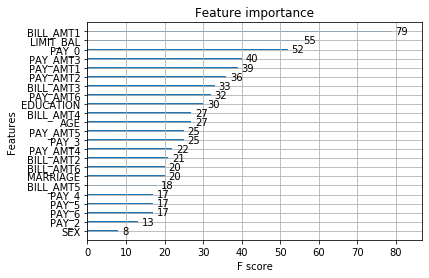

In [33]:
xgb_plot.plot_importance(model_1)

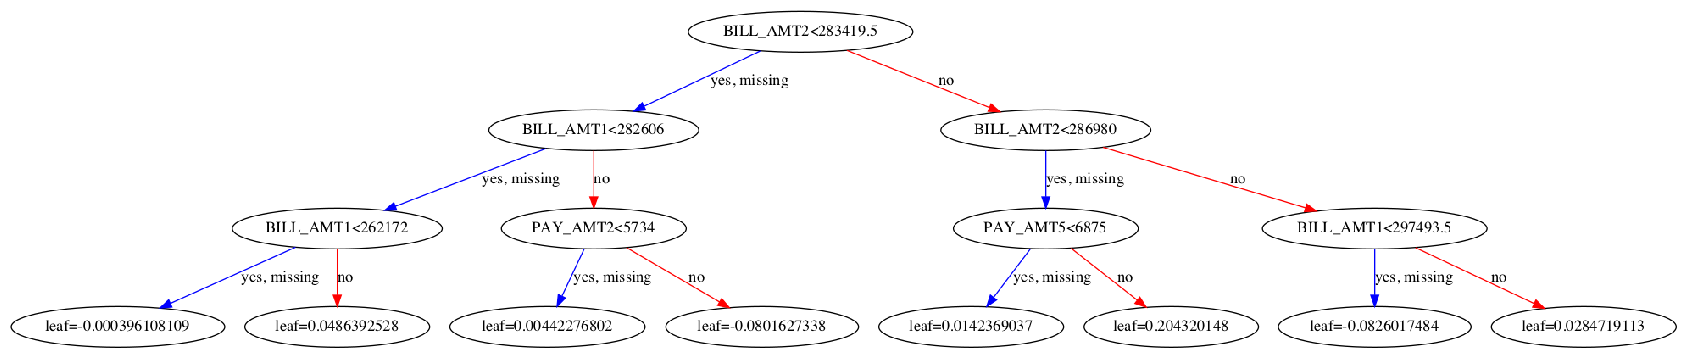

In [30]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(model_1, num_trees=99, ax=ax)
plt.show()

In [ ]:
! pip install graphviz

In [ ]:
plot_tree?

In [ ]:
model_2 = ExtendedXGboost(objective='user:weight').fit(X_train,y_train)
model_2

# Test different gammas

In [ ]:
gammas = [-4,-2,-1,-0.5,0,0.5,1,2,4]

list_auc_train = list()
list_auc_test = list()
list_f1_train = list()
list_f1_test = list()

for gamma in gammas:
    print("gamma {}".format(gamma))
    xgb_model = ExtendedXGboost(n_estimators=100,objective='user:focal', gamma_indct=gamma).fit(X_train,y_train)
    
    auc_train = get_auc(X_train,y_train, xgb_model)
    auc_test = get_auc(X_test,y_test, xgb_model)
    
    f1_train = get_f1(X_train,y_train, xgb_model)
    f1_test = get_f1(X_test,y_test, xgb_model)
    
    list_auc_train.append(auc_train)
    list_auc_test.append(auc_test)
    
    list_f1_train.append(f1_train)
    list_f1_test.append(f1_test)
    
    

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

ax[0].plot(gammas, list_auc_train, label ='auc train', color = 'b')
ax[0].plot(gammas, list_auc_test, label ='auc test', color = 'r')

ax[1].plot(gammas, list_f1_train, label ='f1 train', color = 'b',linestyle='--')
ax[1].plot(gammas, list_f1_test, label ='f1 test', color = 'r',linestyle='--')

### Test the focal loss

In [ ]:
alphas = [0.5,1.,1.5,2,2.5,3.5,4,5]

list_auc_train = list()
list_auc_test = list()
list_f1_train = list()
list_f1_test = list()

for alpha in alphas:
    print("alpha {}".format(alpha))
    xgb_model = ExtendedXGboost(n_estimators=100,objective='user:weight', 
                                grow_policy='lossguide',
                                reg_lambda=1000,
                                imbalance_alpha=alpha).fit(X_train,y_train)
    
    auc_train = get_auc(X_train,y_train, xgb_model)
    auc_test = get_auc(X_test,y_test, xgb_model)
    
    f1_train = get_f1(X_train,y_train, xgb_model)
    f1_test = get_f1(X_test,y_test, xgb_model)
    
    list_auc_train.append(auc_train)
    list_auc_test.append(auc_test)
    
    list_f1_train.append(f1_train)
    list_f1_test.append(f1_test)
    

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,8))

ax[0].plot(alphas, list_auc_train, label ='auc train', color = 'b')
ax[0].plot(alphas, list_auc_test, label ='auc test', color = 'r')

ax[1].plot(alphas, list_f1_train, label ='f1 train', color = 'b',linestyle='--')
ax[1].plot(alphas, list_f1_test, label ='f1 test', color = 'r',linestyle='--')

# Test the early stopping

In [ ]:
xgb = ExtendedXGboost(objective='user:weight', imbalance_alpha=2.5,n_estimators=1000, learning_rate=0.05)

In [ ]:
xgb.fit?

In [ ]:
%%time

eval_set = [(X_train,y_train),(X_test, y_test)]

xgb.fit(
    X_train, y_train, 
    eval_metric=["auc",'aucpr'], 
    eval_set=eval_set, 
    verbose=15, # after how many training sets you want the printout on the console
    early_stopping_rounds=10
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
results = xgb.evals_result()

epochs = len(results['validation_0']['aucpr'])
x_axis = range(0, epochs)

fig, ax = plt.subplots(1,2,figsize = (20,8))
ax[0].plot(x_axis, results['validation_0']['aucpr'], label='Train')
ax[0].plot(x_axis, results['validation_1']['aucpr'], label='Test')
ax[0].set_title('LogLoss')
ax[1].plot(x_axis, results['validation_0']['auc'], label='Train')
ax[1].plot(x_axis, results['validation_1']['auc'], label='Test')
ax[1].set_title('AUC')

### Build a dmatrix

In [ ]:
import xgboost as xgb
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
xgb_params = {
    "n_estimators":500,
    
    'objective':weighted_binary_cross_entropy,
    "learning_rate":0.05,
    "imbalance_alpha": 40
}

param = {'max_depth': 2, 'eta': 1, 'silent': 1}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 2

In [ ]:
xgb.train(
    params = xgb_params,
    dtrain=dtrain,
    evals =watchlist,
    obj=weighted_binary_cross_entropy,
    feval=evalerror
)

In [ ]:
#!/usr/bin/python
import numpy as np
import xgboost as xgb
###
# advanced: customized loss function
#
print('start running example to used customized objective function')

# dtrain = xgb.DMatrix('../data/agaricus.txt.train')
# dtest = xgb.DMatrix('../data/agaricus.txt.test')

# note: for customized objective function, we leave objective as default
# note: what we are getting is margin value in prediction
# you must know what you are doing
param = {"n_estimators":100,'max_depth': 2, 'eta': 1, 'silent': 1}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 2


# user define objective function, given prediction, return gradient and second
# order gradient this is log likelihood loss
# def logregobj(preds, dtrain):
#     labels = dtrain.get_label()
#     preds = 1.0 / (1.0 + np.exp(-preds))
#     grad = preds - labels
#     hess = preds * (1.0 - preds)
#     return grad, hess

def weighted_binary_cross_entropy(preds, dtrain):
       
    imbalance_alpha = 10
    # retrieve data from dtrain matrix
    label = dtrain.get_label()
    # compute the prediction with sigmoid
    sigmoid_pred = 1.0 / (1.0 + np.exp(-preds))
    # gradient
    grad = -(imbalance_alpha ** label) * (label - sigmoid_pred)
    hess = (imbalance_alpha ** label) * sigmoid_pred * (1.0 - sigmoid_pred)

    return grad, hess


# user defined evaluation function, return a pair metric_name, result

# NOTE: when you do customized loss function, the default prediction value is
# margin. this may make builtin evaluation metric not function properly for
# example, we are doing logistic loss, the prediction is score before logistic
# transformation the builtin evaluation error assumes input is after logistic
# transformation Take this in mind when you use the customization, and maybe
# you need write customized evaluation function
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a
    # colon (:) or a space since preds are margin(before logistic
    # transformation, cutoff at 0)
    return 'my-error', float(sum(labels != (preds > 0.0))) / len(labels)




# training with customized objective, we can also do step by step training
# simply look at xgboost.py's implementation of train
bst = xgb.train(param, dtrain, 
                num_round, 
                watchlist, 
                obj=weighted_binary_cross_entropy,
                feval=evalerror)

In [ ]:
xgb.train?

In [ ]:
#!/usr/bin/python
import numpy as np
import xgboost as xgb
###
# advanced: customized loss function
#
print('start running example to used customized objective function')

# dtrain = xgb.DMatrix('../data/agaricus.txt.train')
# dtest = xgb.DMatrix('../data/agaricus.txt.test')

# note: for customized objective function, we leave objective as default
# note: what we are getting is margin value in prediction
# you must know what you are doing
param = {'max_depth': 2, 'eta': 1, 'silent': 1}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 10


# user define objective function, given prediction, return gradient and second
# order gradient this is log likelihood loss
def logregobj(preds, dtrain):
    labels = dtrain.get_label()
    preds = 1.0 / (1.0 + np.exp(-preds))
    grad = preds - labels
    hess = preds * (1.0 - preds)
    return grad, hess


# user defined evaluation function, return a pair metric_name, result

# NOTE: when you do customized loss function, the default prediction value is
# margin. this may make builtin evaluation metric not function properly for
# example, we are doing logistic loss, the prediction is score before logistic
# transformation the builtin evaluation error assumes input is after logistic
# transformation Take this in mind when you use the customization, and maybe
# you need write customized evaluation function
def evalerror(preds, dtrain):
    labels = dtrain.get_label()
    # return a pair metric_name, result. The metric name must not contain a
    # colon (:) or a space since preds are margin(before logistic
    # transformation, cutoff at 0)
    return 'my-error', float(sum(labels != (preds > 0.0))) / len(labels)


# training with customized objective, we can also do step by step training
# simply look at xgboost.py's implementation of train
bst = xgb.train(param, dtrain, num_round, watchlist, obj=logregobj,
                feval=evalerror)